In [1]:
import io
import sys
from pathlib import Path

import librosa
import numpy as np
from IPython.display import HTML, display
from scipy.io import wavfile

# Project root for paths
project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent.parent
sys.path.insert(0, str(project_root))
from dijon.global_config import RAW_AUDIO_DIR

# YTB-005 HEAD_IN segment (from YTB-005_markers.json)
audio_path = RAW_AUDIO_DIR / "YTB-005.wav"
start_s, end_s = 1.12202155589225, 32.67362954572256
y, sr = librosa.load(audio_path, sr=None, mono=True, offset=start_s, duration=end_s - start_s)

In [2]:
harm, perc = 100, 31
mh, mp = 1.0, 12.0
power = 2.0

S = librosa.stft(y)
H, P = librosa.decompose.hpss(S, kernel_size=(harm, perc), margin=(mh, mp), power=power, mask=False)

y_harm = librosa.istft(H, length=len(y))
y_perc = librosa.istft(P, length=len(y))

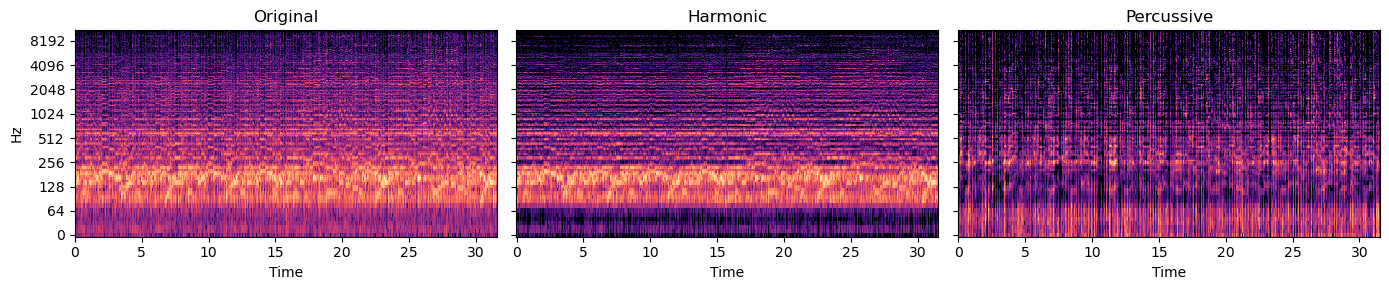

In [3]:
import base64

def audio_player_html(x, sr, max_width_px=320):
    x_arr = np.asarray(x)
    x_int16 = (np.clip(x_arr, -1, 1) * 32767).astype(np.int16)
    buf = io.BytesIO()
    wavfile.write(buf, int(sr), x_int16)
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode()
    return f'<div style="max-width:{max_width_px}px;"><audio controls style="width:100%;"><source src="data:audio/wav;base64,{b64}" type="audio/wav"></audio></div>'

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
for ax, spec, title in zip(axes, [S, H, P], ["Original", "Harmonic", "Percussive"]):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec), ref=np.max),
                             sr=sr, y_axis="log", x_axis="time", ax=ax)
    ax.set_title(title)
axes[0].set_ylabel("Hz")
for ax in axes[1:]:
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

display(HTML("<b>Original (HEAD_IN)</b>"))
display(HTML(audio_player_html(y, sr)))
display(HTML("<b>Harmonic</b>"))
display(HTML(audio_player_html(y_harm, sr)))
display(HTML("<b>Percussive</b>"))
display(HTML(audio_player_html(y_perc, sr)))